In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Import Tree Models from scratch functions
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/TreeModelsFromScratch")

from DecisionTree import DecisionTree
from RandomForest import RandomForest
from SmoothShap import verify_shap_model, smooth_shap, cross_val_score_scratch, export_imodels_for_SHAP, GridSearchCV_scratch

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_friedman1
import matplotlib.pyplot as plt
import matplotlib as mpl
from imodels import HSTreeClassifier, HSTreeRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from copy import deepcopy
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
from shap import TreeExplainer
from sklearn.metrics import r2_score
import pickle
from datetime import datetime

In [4]:
# Gloabl figure settings
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [6]:
#for storing results
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","friedman1_simulation")
today_str = datetime.today().strftime("%Y%m%d")

# `"Friedman1"` simulation 
`Friedman1` (also referred as `MARS` simulation) [source] was also used as one of the benchmark datasets in the HS paper []. <br>
- HS paper calls a function which is implemented in imodels [`get_clean_dataset` function](https://github.com/csinva/imodels/blob/3c6ebbd4868711efaf237da99711dea747124aba/imodels/util/data_util.py#L119) to create the so called "friedman1" dataset
- The imodels function however just calls the sklearn `make_friedman1` [function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html)

**Definition from sklearn**<br>
Inputs `X` are independent features uniformly distributed on the interval [0, 1]. The output `y` is created according to the formula: <br>
`y(X) = 10 * sin(pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 + 10 * X[:, 3] + 5 * X[:, 4] + noise * N(0, 1)`
<br>
Out of the `n_features` features, only 5 are actually used to compute `y`. The remaining features are independent of `y`.

- Friedman, Grosse ans Stuetzle (1983) originally created this function to uncover interaction effects that are present in data. In the original setting they used `n_samples=200` and `n_features=6` (one noisy feature)
- Mentch (2020) used the same function in his paper (source), but in a more difficult setting. They reduced the `n_samples=100` and increased the `n_features=10` so that there are 5 noise features independent of f(x)
- The HS paper used the same function with `n_samples=200` and `n_features=10`

For this thesis, we will also use the syntetic dataset with the same parameter settings as in the HS paper: `n_samples=200` and `n_features=10` <br>
A lower sample size of 100 (as in simulation by Mentch) should "only" increase variability within the results?

## Create function

In [7]:
def simulate_friedman1(n_samples=200, n_features=10, n_trees=1, M=100, reg_param=10, random_seed=None):
    
    random_state = np.random.RandomState(random_seed)
    
    #X and y
    Xs = np.empty((M, n_samples, n_features))
    ys = np.empty((M, n_samples))
    
    #MDI
    mdi_sk = [] #sklearn
    mdi_im = [] #imodels
    mdi_scr = [] #scratch
    mdi_scrHS = [] #scratch with HS
    
    #SHAP
    shap_sk = [] #sklearn
    shap_im = [] #imodels
    shap_scr = [] #scratch
    shap_scr_inbag = [] #scratch
    shap_scr_oob = [] #scratch
    shap_scrHS = [] #scratch with HS
    shap_scrHS_inbag = [] #scratch with HS
    shap_scrHS_oob = [] #scratch with HS
    
    #Smooth SHAP
    smshap_scr = [] #scratch
    smshap_scrHS = [] #scratch with HS
    
    for i in range(M):
        
        # Create dataset
        X, y = make_friedman1(n_samples=n_samples, n_features=n_features, noise=0.0)
        Xs[i,:,:] = X
        ys[i,:] = y
        
        #Fit sklearn
        if n_trees==1:
            reg_sk = DecisionTreeRegressor(random_state=random_seed).fit(X, y)
        else:
            reg_sk = RandomForestRegressor(n_estimators=n_trees, random_state=random_seed).fit(X, y)
        mdi_sk.append(reg_sk.feature_importances_) #MDI
        explainer_sk = TreeExplainer(reg_sk)
        shap_values_sk = explainer_sk.shap_values(X) #shap
        shap_sk.append(shap_values_sk)
            
        #Fit imodels
        reg_im = HSTreeRegressor(deepcopy(reg_sk), reg_param=reg_param)
        mdi_im.append(reg_im.estimator_.feature_importances_) #MDI
        export_im = export_imodels_for_SHAP(reg_im, is_forest=False if n_trees==1 else True)
        explainer_im = TreeExplainer(export_im)
        shap_values_im = explainer_im.shap_values(X) #shap
        shap_im.append(shap_values_im)
            
        #Fit scratch
        if n_trees==1:
            reg_scr = DecisionTree(treetype="regression", random_state=random_seed)
        else:
            reg_scr = RandomForest(n_trees=n_trees, oob_SHAP=True, treetype="regression", random_state=random_seed)
        reg_scr.fit(X, y)
        mdi_scr.append(reg_scr.feature_importances_) #MDI
        if n_trees==1:
            export_model_scr = reg_scr.export_tree_for_SHAP()
        else:
            export_model_scr = reg_scr.export_forest_for_SHAP()
        explainer_scr = TreeExplainer(export_model_scr)
        shap_values_scr = explainer_scr.shap_values(X)
        shap_scr.append(shap_values_scr) #SHAP
        if n_trees!=1:
            shap_scr_inbag.append(reg_scr.inbag_SHAP_values) # shap inbag
            shap_scr_oob.append(reg_scr.oob_SHAP_values) # shap oob
            smooth_shap_vals_scr, _ = smooth_shap(reg_scr.inbag_SHAP_values, reg_scr.oob_SHAP_values) #smooth shap
            smshap_scr.append(smooth_shap_vals_scr)

        #Fit scratch HS
        if n_trees==1:
            reg_scrHS = DecisionTree(treetype="regression", HShrinkage=True, HS_lambda=reg_param, random_state=random_seed)
        else:
            reg_scrHS = RandomForest(n_trees=n_trees, HShrinkage=True, HS_lambda=reg_param, oob_SHAP=True, treetype="regression", random_state=random_seed)
        reg_scrHS.fit(X, y)
        mdi_scrHS.append(reg_scr.feature_importances_) #MDI
        if n_trees==1:
            export_model_scrHS = reg_scrHS.export_tree_for_SHAP()
        else:
            export_model_scrHS = reg_scrHS.export_forest_for_SHAP()
        explainer_scrHS = TreeExplainer(export_model_scrHS)
        shap_values_scrHS = explainer_scrHS.shap_values(X)
        shap_scrHS.append(shap_values_scrHS) #SHAP
        if n_trees!=1:
            shap_scrHS_inbag.append(reg_scrHS.inbag_SHAP_values) # shap inbag
            shap_scrHS_oob.append(reg_scrHS.oob_SHAP_values) # shap oob
            smooth_shap_vals_scrHS, _ = smooth_shap(reg_scrHS.inbag_SHAP_values, reg_scrHS.oob_SHAP_values) #smooth shap
            smshap_scrHS.append(smooth_shap_vals_scrHS)

    #store all observations in lists of lists
    mdi_vals = [mdi_sk, mdi_im, mdi_scr, mdi_scrHS]
    shap_vals = [shap_sk, shap_im, shap_scr, shap_scr_inbag, shap_scr_oob, shap_scrHS, shap_scrHS_inbag, shap_scrHS_oob]
    smshap_vals = [smshap_scr, smshap_scrHS]
    
    Xy = [Xs, ys]
    
    return Xy, mdi_vals, shap_vals, smshap_vals


`n_samples=200` and `n_features=10`

## Single Decision Tree

### GridSearch best hyper parameter for lambda

In [8]:
# Create one dataset and use it to optimize best value for lambda 
X, y = make_friedman1(n_samples=200, n_features=10, noise=0.0, random_state=None)

In [9]:
grid_res = GridSearchCV_scratch(estimator=HSTreeRegressor(DecisionTreeRegressor()), 
                                grid={"reg_param":[0.1,1,5,10,20,25,50,100,200,500]}, 
                                X=X, y=y, cv=10, scoring_func=r2_score, fit_best_est=False)

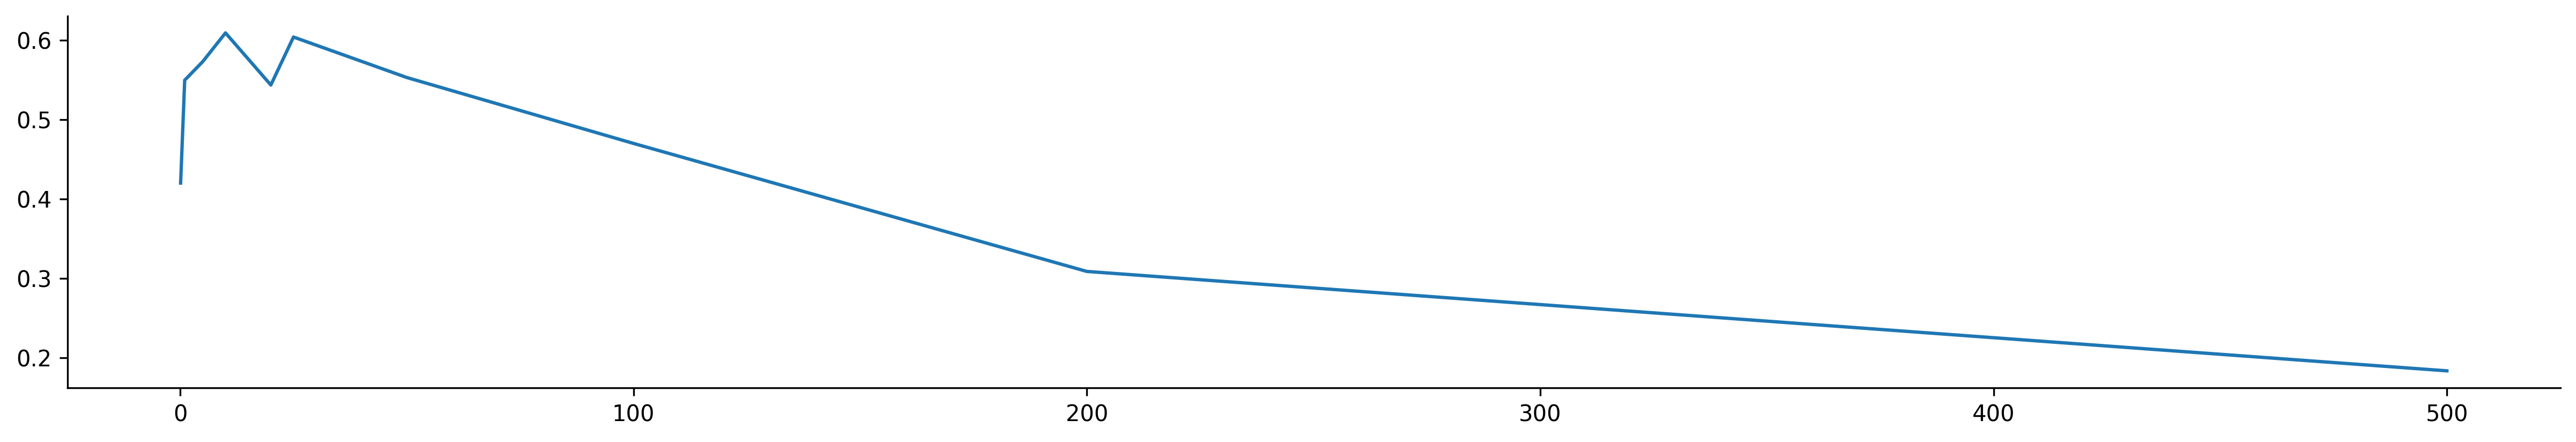

In [10]:
# show mean avg. test score accross all 10 folds
fig, ax = plt.subplots(1,1, figsize=(20,3))
ax.plot(grid_res["param_combinations"], grid_res["mean_test_scores"]);

In [11]:
grid_res["best_param_comb"]

(10,)

### Call function and compute statistics

In [12]:
# %%time
# [Xs, ys], mdi_vals, shap_vals, smshap_vals = simulate_friedman1(
#     n_samples=200, n_features=10, n_trees=1, M=100, reg_param=20, random_seed=None)

CPU times: user 7min 36s, sys: 2.1 s, total: 7min 38s
Wall time: 7min 44s


In [13]:
# # #Store results as pkl
# friedman1_20_tree = [[Xs, ys], mdi_vals, shap_vals, smshap_vals]

# with open(f'{data_path}/{today_str}_friedman1_20_tree.pickle', 'wb') as handle:
#     pickle.dump(friedman1_20_tree, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
# Load pickle results
with open(f'{data_path}/20221031_friedman1_20_tree.pickle', 'rb') as handle:
    [[Xs, ys], mdi_vals, shap_vals, smshap_vals] = pickle.load(handle)

### MDI

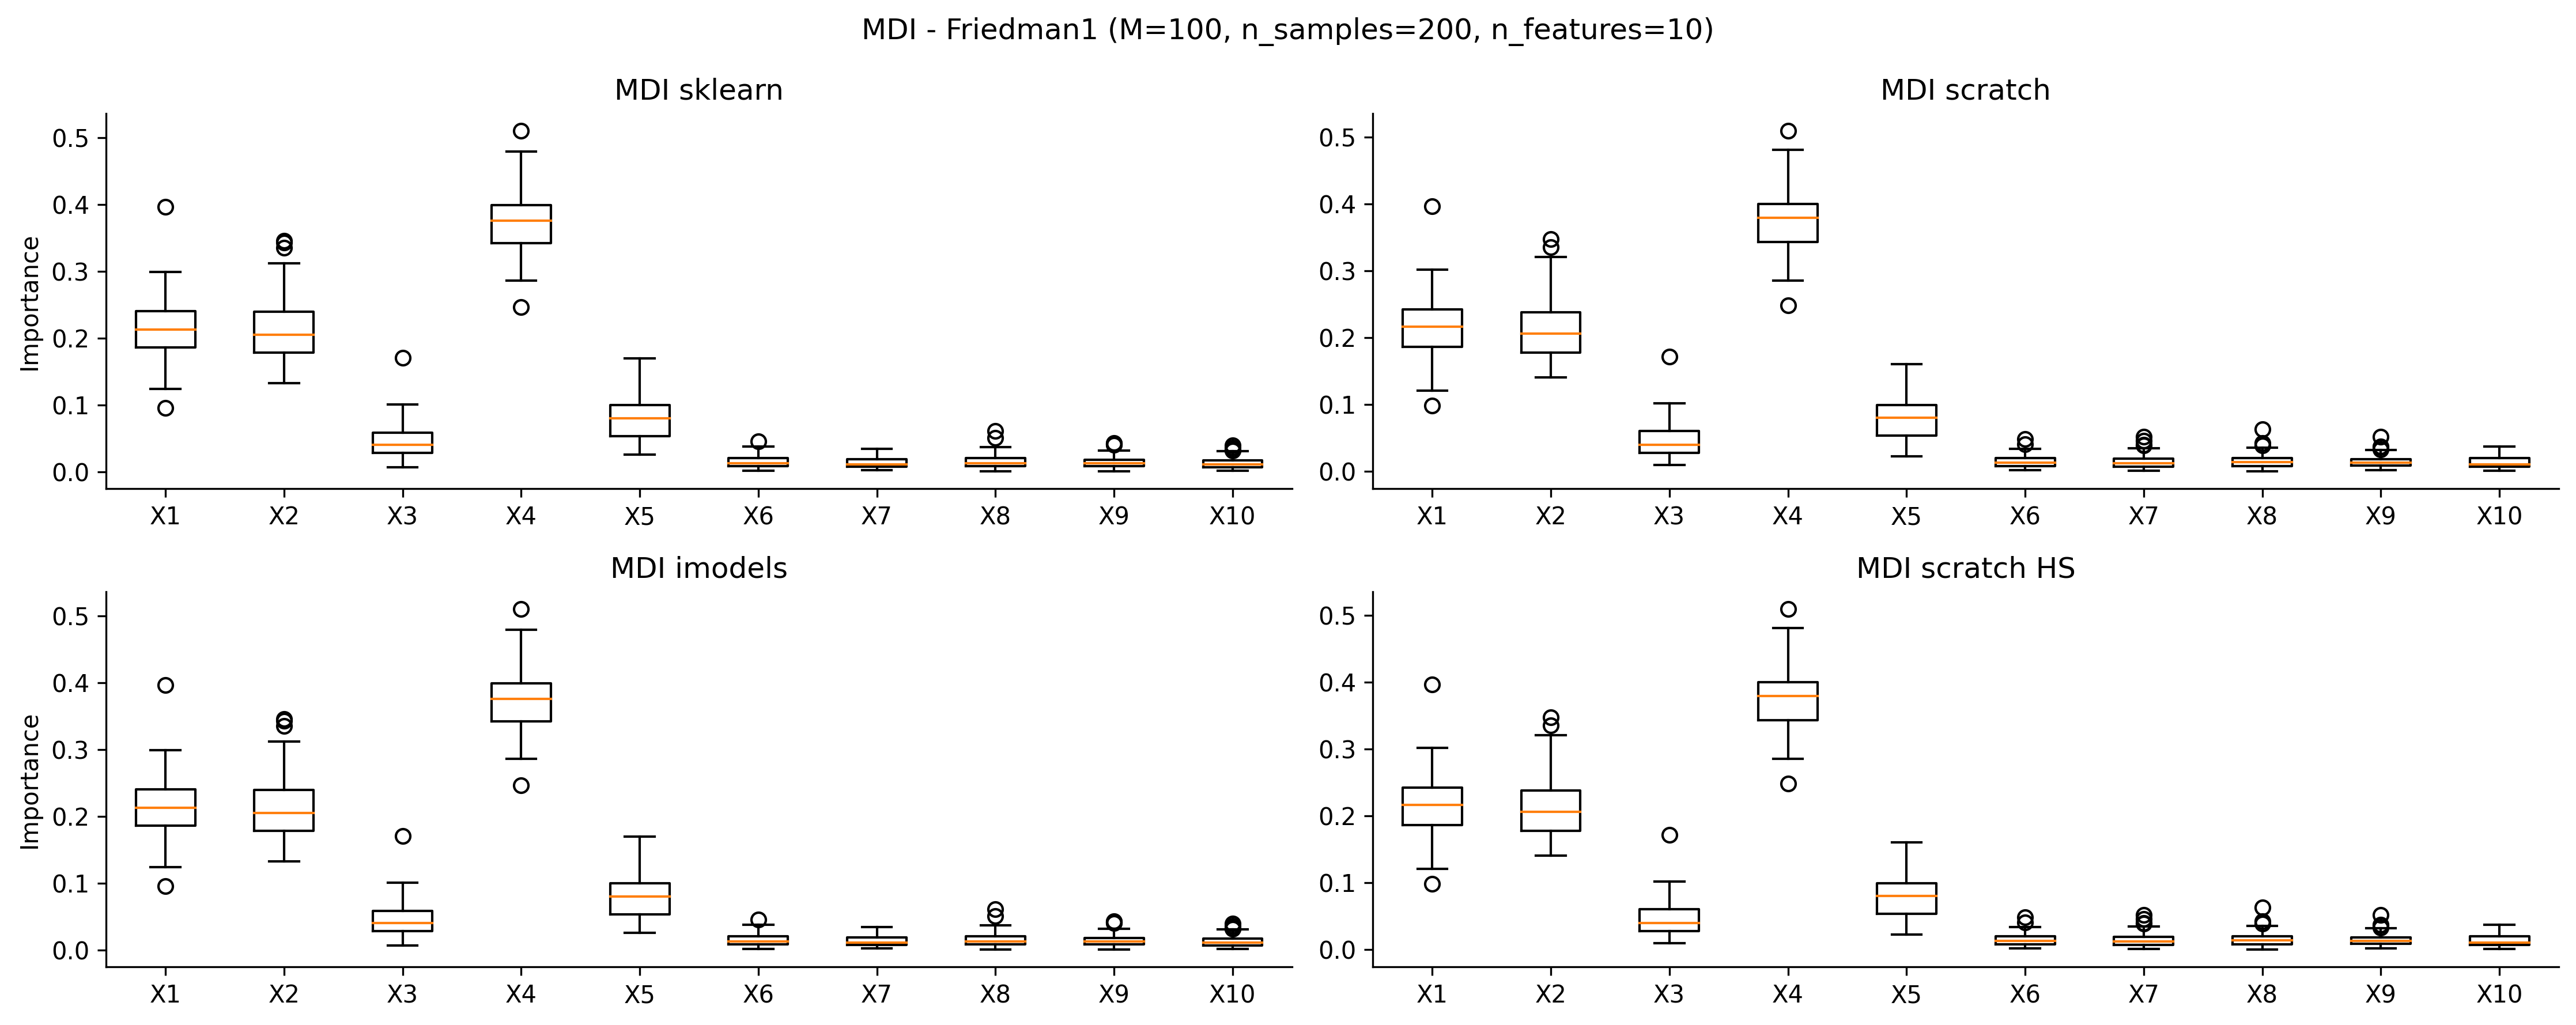

In [9]:
#MDI
fig, axs = plt.subplots(2,2, figsize=(15,6))
x_label = ["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10"]

fig.suptitle('MDI - Friedman1 (M=100, n_samples=200, n_features=10)')           
axs[0,0].boxplot(np.array(mdi_vals[0]), labels=x_label)
axs[0,0].set_title('MDI sklearn')
axs[0,0].set_ylabel("Importance")
axs[1,0].boxplot(np.array(mdi_vals[1]), labels=x_label)
axs[1,0].set_title('MDI imodels')

axs[1,0].set_ylabel("Importance")
axs[0,1].boxplot(np.array(mdi_vals[2]), labels=x_label)
axs[0,1].set_title('MDI scratch')
axs[1,1].boxplot(np.array(mdi_vals[3]), labels=x_label)
axs[1,1].set_title('MDI scratch HS')

#plt.setp(axs, ylim=[-.02,0.7]); #set global ylim for all suplots

plt.tight_layout()

### SHAP values

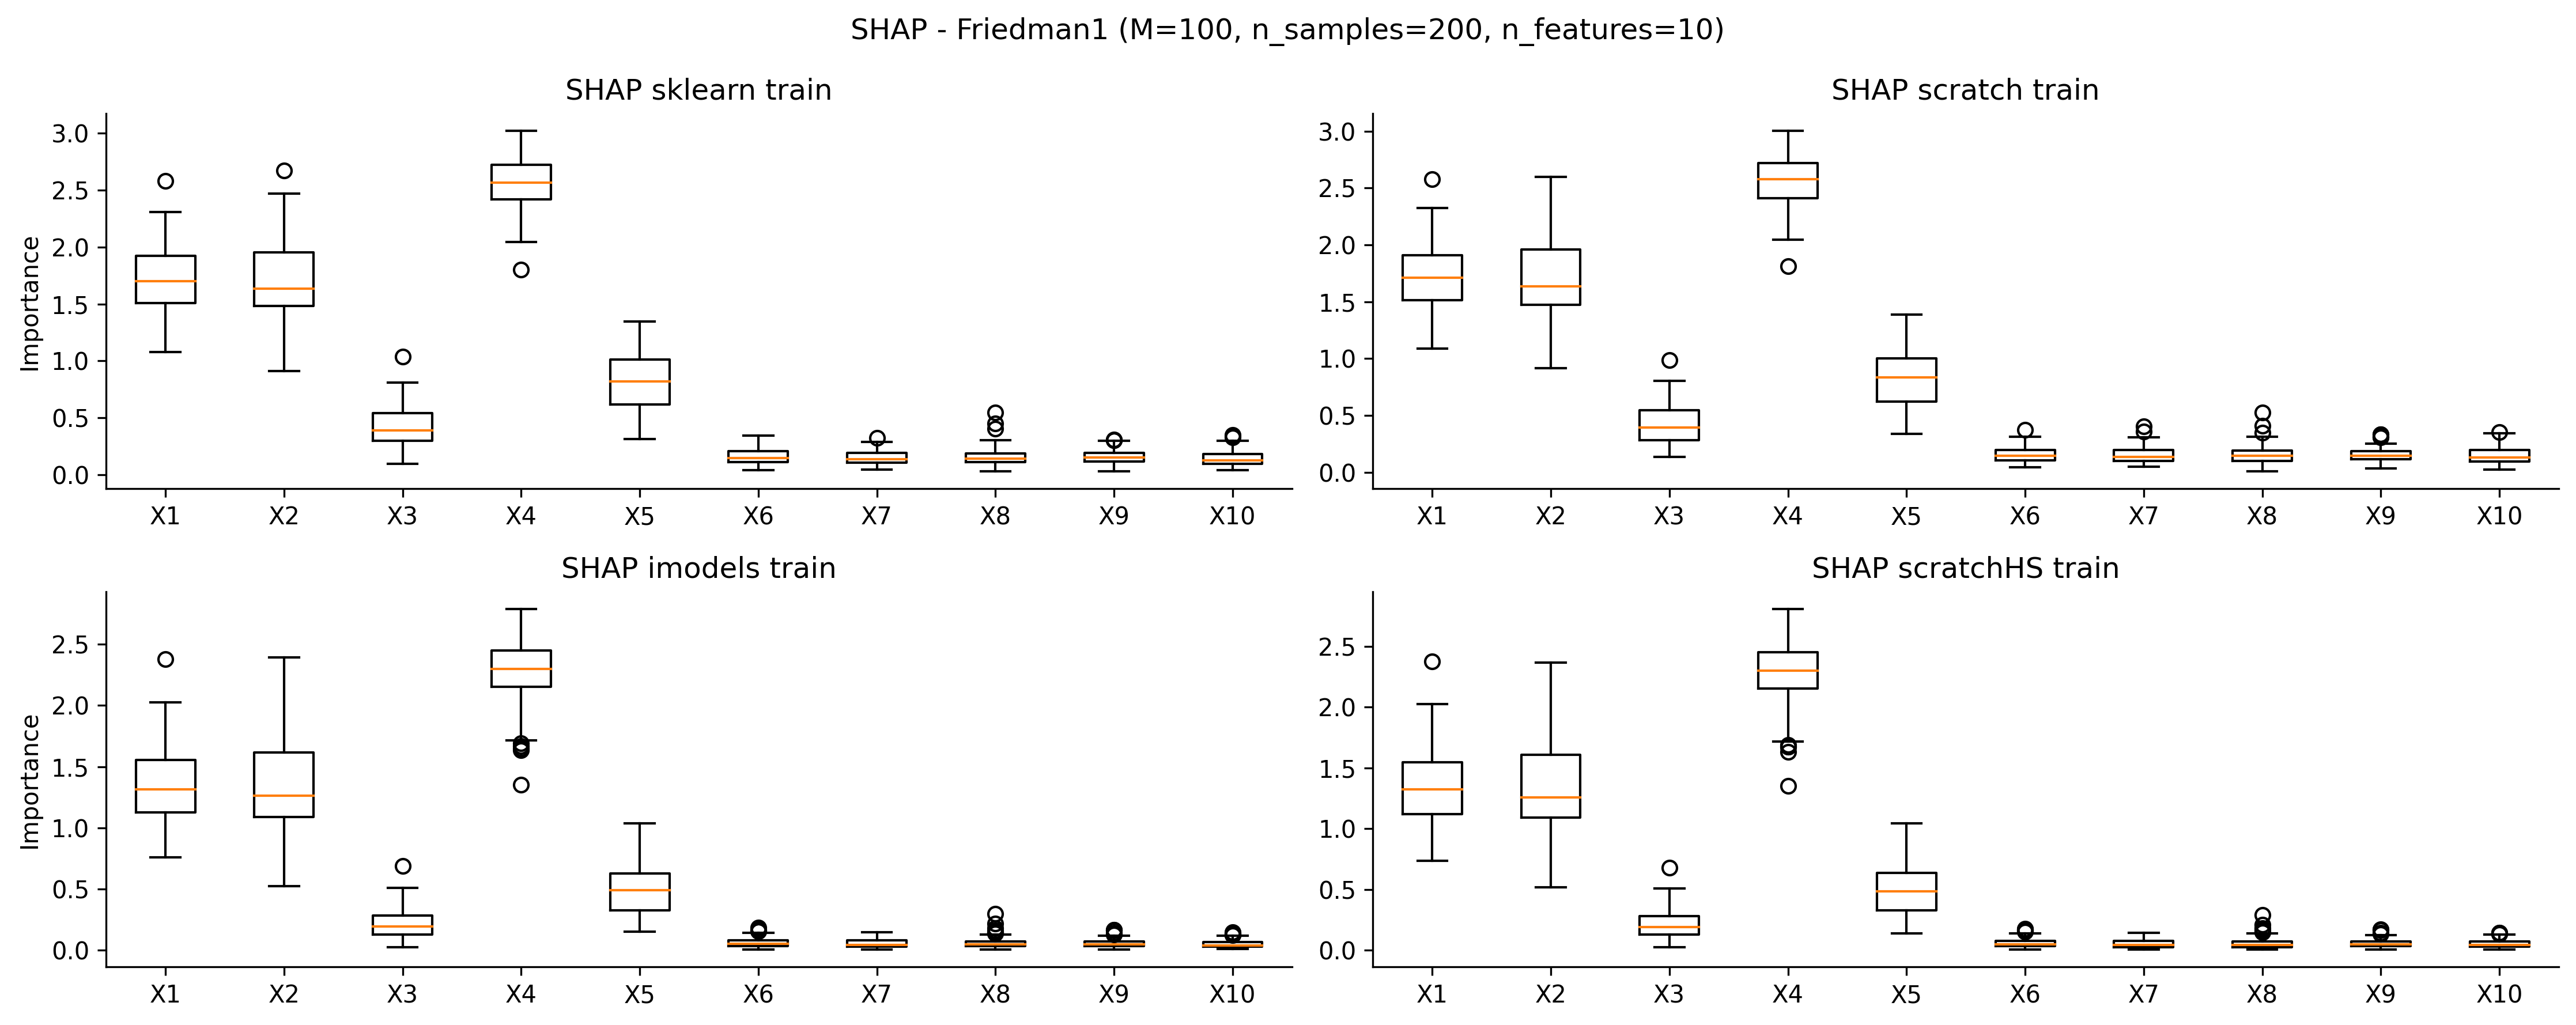

In [10]:
#SHAP
fig, axs = plt.subplots(2,2, figsize=(15,6))
x_label = ["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10"]

fig.suptitle('SHAP - Friedman1 (M=100, n_samples=200, n_features=10)')           
axs[0,0].boxplot(np.abs(np.array(shap_vals[0])).mean(axis=1), labels=x_label)
axs[0,0].set_title('SHAP sklearn train')
axs[0,0].set_ylabel("Importance")
axs[0,1].boxplot(np.abs(np.array(shap_vals[2])).mean(axis=1), labels=x_label)
axs[0,1].set_title('SHAP scratch train')

axs[1,0].set_ylabel("Importance")
axs[1,0].boxplot(np.abs(np.array(shap_vals[1])).mean(axis=1), labels=x_label)
axs[1,0].set_title('SHAP imodels train')
axs[1,1].boxplot(np.abs(np.array(shap_vals[5])).mean(axis=1), labels=x_label)
axs[1,1].set_title('SHAP scratchHS train')

#plt.setp(axs, ylim=[-.02,0.7]); #set global ylim for all suplots

plt.tight_layout()

## Random Forest
`n_estimators=20`

### GridSearch best hyper parameter for lambda

In [11]:
# Create one dataset and use it to optimize best value for lambda 
X, y = make_friedman1(n_samples=200, n_features=10, noise=0.0, random_state=None)

In [12]:
grid_res = GridSearchCV_scratch(estimator=HSTreeRegressor(RandomForestRegressor(n_estimators=20)), 
                                grid={"reg_param":[0.001, 0.1,1,5,10,20,25,50,100,200,500]}, 
                                X=X, y=y, cv=10, scoring_func=r2_score, fit_best_est=False)

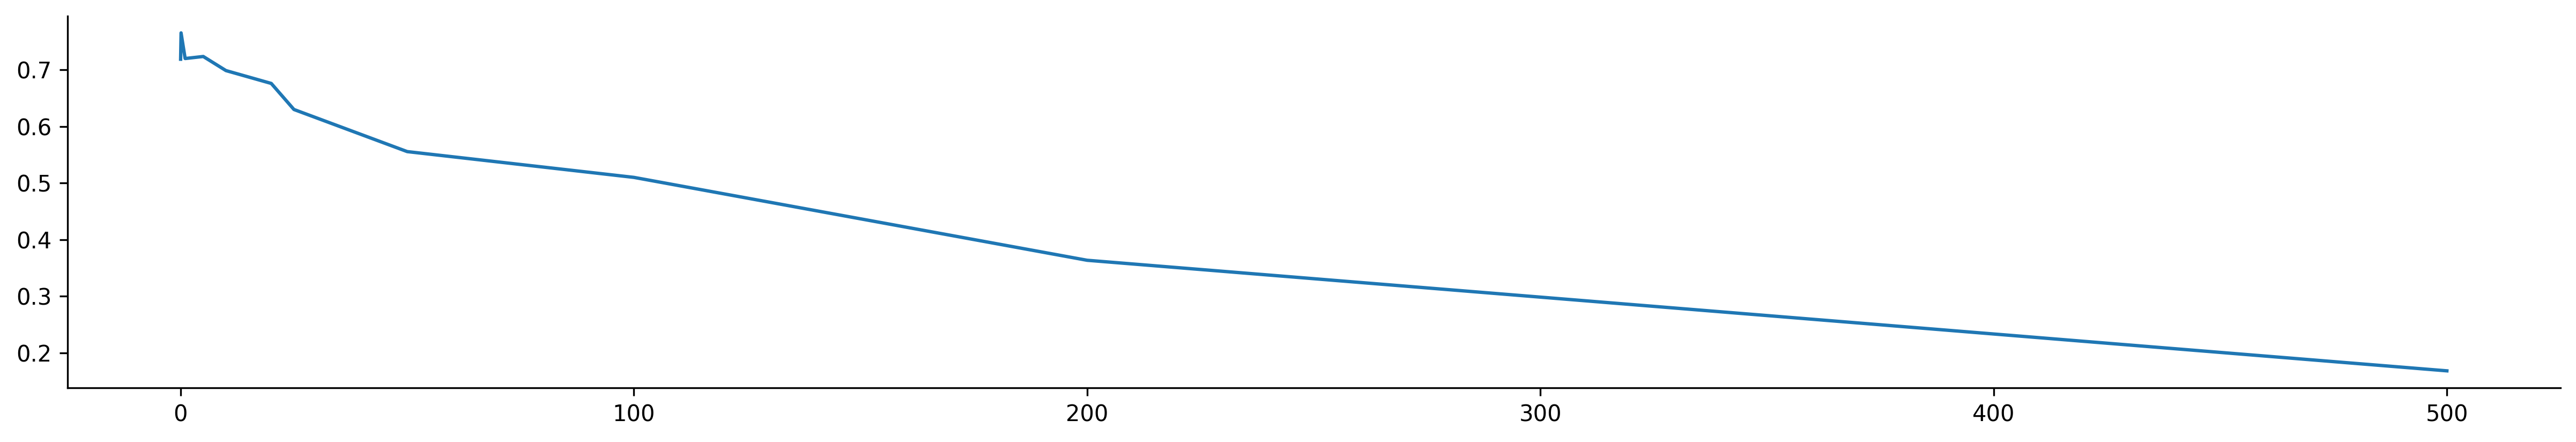

In [13]:
# show mean avg. test score accross all 10 folds
fig, ax = plt.subplots(1,1, figsize=(20,3))
ax.plot(grid_res["param_combinations"], grid_res["mean_test_scores"]);

In [14]:
grid_res["best_param_comb"]

(0.1,)

In [ ]:
%%time
[X_rf, y_rf], mdi_vals_rf, shap_vals_rf, smshap_vals_rf = simulate_friedman1(
    n_samples=200, n_features=10, n_trees=20, M=100, reg_param=1, random_seed=None)

In [ ]:
# #Store results as pkl
friedman1_1_forest = [X_rf, y_rf], mdi_vals_rf, shap_vals_rf, smshap_vals_rf

with open(f'{data_path}/{today_str}_friedman1_1_forest_100.pickle', 'wb') as handle:
    pickle.dump(friedman1_1_forest, handle, protocol=pickle.HIGHEST_PROTOCOL)

### MDI

In [ ]:
#MDI
fig, axs = plt.subplots(2,2, figsize=(15,6))
x_label = ["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10"]

fig.suptitle('MDI - Friedman1 (M=100, n_samples=200, n_features=10)')           
axs[0,0].boxplot(np.array(mdi_vals_rf[0]), labels=x_label)
axs[0,0].set_title('MDI sklearn')
axs[0,0].set_ylabel("Importance")
axs[1,0].boxplot(np.array(mdi_vals_rf[1]), labels=x_label)
axs[1,0].set_title('MDI imodels')

axs[1,0].set_ylabel("Importance")
axs[0,1].boxplot(np.array(mdi_vals_rf[2]), labels=x_label)
axs[0,1].set_title('MDI scratch')
axs[1,1].boxplot(np.array(mdi_vals_rf[3]), labels=x_label)
axs[1,1].set_title('MDI scratch HS')

#plt.setp(axs, ylim=[-.02,0.7]); #set global ylim for all suplots

plt.tight_layout()

### SHAP values

In [ ]:
#SHAP
fig, axs = plt.subplots(2,4, figsize=(15,6))
x_label = ["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10"]

fig.suptitle('SHAP - Friedman1 (M=100, n_samples=200, n_features=10)')           
axs[0,0].boxplot(np.abs(np.array(shap_vals_rf[0])).mean(axis=1), labels=x_label)
axs[0,0].set_title('SHAP sklearn train')
axs[0,0].set_ylabel("Importance")
axs[0,1].boxplot(np.abs(np.array(shap_vals_rf[2])).mean(axis=1), labels=x_label)
axs[0,1].set_title('SHAP scratch train')
axs[0,2].boxplot(np.abs(np.array(shap_vals_rf[3])).mean(axis=1), labels=x_label)
axs[0,2].set_title('SHAP scratch inbag')
axs[0,3].boxplot(np.abs(np.array(shap_vals_rf[4])).mean(axis=1), labels=x_label)
axs[0,3].set_title('SHAP scratch oob')

axs[1,0].set_ylabel("Importance")
axs[1,0].boxplot(np.abs(np.array(shap_vals_rf[1])).mean(axis=1), labels=x_label)
axs[1,0].set_title('SHAP imodels train')
axs[1,1].boxplot(np.abs(np.array(shap_vals_rf[5])).mean(axis=1), labels=x_label)
axs[1,1].set_title('SHAP scratchHS train')
axs[1,2].boxplot(np.abs(np.array(shap_vals_rf[6])).mean(axis=1), labels=x_label)
axs[1,2].set_title('SHAP scratchHS inbag')
axs[1,3].boxplot(np.abs(np.array(shap_vals_rf[7])).mean(axis=1), labels=x_label)
axs[1,3].set_title('SHAP scratchHS oob')

#plt.setp(axs, ylim=[-.02,0.7]); #set global ylim for all suplots

plt.tight_layout()

### Smooth SHAP values

In [ ]:
#SHAP
fig, axs = plt.subplots(2,2, figsize=(15,6))
x_label = ["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10"]

fig.suptitle('SHAP - Friedman1 (M=100, n_samples=200, n_features=10)')           
axs[0,0].boxplot(np.abs(np.array(shap_vals_rf[2])).mean(axis=1), labels=x_label)
axs[0,0].set_title('SHAP scratch train')
axs[0,0].set_ylabel("Importance")
axs[0,1].boxplot(np.abs(np.array(smshap_vals_rf[0])).mean(axis=1), labels=x_label)
axs[0,1].set_title('Smooth SHAP scratch')

axs[1,0].boxplot(np.abs(np.array(shap_vals_rf[5])).mean(axis=1), labels=x_label)
axs[1,0].set_title('SHAP scratchHS train')
axs[1,0].set_ylabel("Importance")
axs[1,1].boxplot(np.abs(np.array(smshap_vals_rf[1])).mean(axis=1), labels=x_label)
axs[1,1].set_title('Smooth SHAP scratchHS')

#plt.setp(axs, ylim=[-.02,0.7]); #set global ylim for all suplots

plt.tight_layout()